<a href="https://colab.research.google.com/github/xehau/xehau_lessons/blob/master/overfit_and_underfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 過学習と学習不足について知る

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/overfit_and_underfit"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Note: これらのドキュメントは私たちTensorFlowコミュニティが翻訳したものです。コミュニティによる 翻訳は**ベストエフォート**であるため、この翻訳が正確であることや[英語の公式ドキュメント](https://www.tensorflow.org/?hl=en)の 最新の状態を反映したものであることを保証することはできません。 この翻訳の品質を向上させるためのご意見をお持ちの方は、GitHubリポジトリ[tensorflow/docs](https://github.com/tensorflow/docs)にプルリクエストをお送りください。 コミュニティによる翻訳やレビューに参加していただける方は、 [docs-ja@tensorflow.org メーリングリスト](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-ja)にご連絡ください。

いつものように、この例のプログラムは`tf.keras` APIを使用します。詳しくはTensorFlowの[Keras guide](https://www.tensorflow.org/guide/keras)を参照してください。

これまでの例、つまり、映画レビューの分類と燃費の推定では、検証用データでのモデルの正解率が、数エポックでピークを迎え、その後低下するという現象が見られました。

言い換えると、モデルが訓練用データを**過学習**したと考えられます。過学習への対処の仕方を学ぶことは重要です。**訓練用データセット**で高い正解率を達成することは難しくありませんが、我々は、（これまで見たこともない）**テスト用データ**に汎化したモデルを開発したいのです。

過学習の反対語は**学習不足**(underfitting)です。学習不足は、モデルがテストデータに対してまだ改善の余地がある場合に発生します。学習不足の原因は様々です。モデルが十分強力でないとか、正則化のしすぎだとか、単に訓練時間が短すぎるといった理由があります。学習不足は、訓練用データの中の関連したパターンを学習しきっていないということを意味します。

モデルの訓練をやりすぎると、モデルは過学習を始め、訓練用データの中のパターンで、テストデータには一般的ではないパターンを学習します。我々は、過学習と学習不足の中間を目指す必要があります。これから見ていくように、ちょうどよいエポック数だけ訓練を行うというのは必要なスキルなのです。

過学習を防止するための、最良の解決策は、より多くの訓練用データを使うことです。多くのデータで訓練を行えば行うほど、モデルは自然により汎化していく様になります。これが不可能な場合、次善の策は正則化のようなテクニックを使うことです。正則化は、モデルに保存される情報の量とタイプに制約を課すものです。ネットワークが少数のパターンしか記憶できなければ、最適化プロセスにより、最も主要なパターンのみを学習することになり、より汎化される可能性が高くなります。

このノートブックでは、重みの正則化とドロップアウトという、よく使われる2つの正則化テクニックをご紹介します。これらを使って、IMDBの映画レビューを分類するノートブックの改善を図ります。

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.4.1


## IMDBデータセットのダウンロード

以前のノートブックで使用したエンベディングの代わりに、ここでは文をマルチホットエンコードします。このモデルは、訓練用データセットをすぐに過学習します。このモデルを使って、過学習がいつ起きるかということと、どうやって過学習と戦うかをデモします。

リストをマルチホットエンコードすると言うのは、0と1のベクトルにするということです。具体的にいうと、例えば`[3, 5]`というシーケンスを、インデックス3と5の値が1で、それ以外がすべて0の、10,000次元のベクトルに変換するということを意味します。

In [ ]:
NUM_WORDS = 10000

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

def multi_hot_sequences(sequences, dimension):
    # 形状が (len(sequences), dimension)ですべて0の行列を作る
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # 特定のインデックスに対してresults[i] を１に設定する
    return results


train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

結果として得られるマルチホットベクトルの1つを見てみましょう。単語のインデックスは頻度順にソートされています。このため、インデックスが0に近いほど１が多く出現するはずです。分布を見てみましょう。

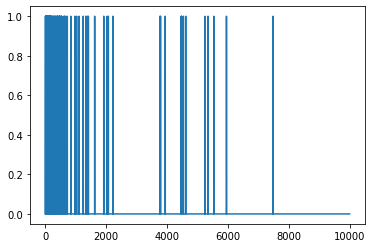

In [ ]:
plt.plot(train_data[0])

## 過学習のデモ

過学習を防止するための最も単純な方法は、モデルのサイズ、すなわち、モデル内の学習可能なパラメータの数を小さくすることです（学習パラメータの数は、層の数と層ごとのユニット数で決まります）。ディープラーニングでは、モデルの学習可能なパラメータ数を、しばしばモデルの「キャパシティ」と呼びます。直感的に考えれば、パラメータ数の多いモデルほど「記憶容量」が大きくなり、訓練用のサンプルとその目的変数の間の辞書のようなマッピングをたやすく学習することができます。このマッピングには汎化能力がまったくなく、これまで見たことが無いデータを使って予測をする際には役に立ちません。

ディープラーニングのモデルは訓練用データに適応しやすいけれど、本当のチャレレンジは汎化であって適応ではないということを、肝に銘じておく必要があります。

一方、ネットワークの記憶容量が限られている場合、前述のようなマッピングを簡単に学習することはできません。損失を減らすためには、より予測能力が高い圧縮された表現を学習しなければなりません。同時に、モデルを小さくしすぎると、訓練用データに適応するのが難しくなります。「多すぎる容量」と「容量不足」の間にちょうどよい容量があるのです。

残念ながら、（層の数や、層ごとの大きさといった）モデルの適切なサイズやアーキテクチャを決める魔法の方程式はありません。一連の異なるアーキテクチャを使って実験を行う必要があります。

適切なモデルのサイズを見つけるには、比較的少ない層の数とパラメータから始めるのがベストです。それから、検証用データでの損失値の改善が見られなくなるまで、徐々に層の大きさを増やしたり、新たな層を加えたりします。映画レビューの分類ネットワークでこれを試してみましょう。

比較基準として、```Dense```層だけを使ったシンプルなモデルを構築し、その後、それより小さいバージョンと大きいバージョンを作って比較します。

### 比較基準を作る

In [ ]:
baseline_model = keras.Sequential([
    # `.summary` を見るために`input_shape`が必要 
    keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
baseline_history = baseline_model.fit(train_data,
                                      train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2)

Epoch 1/20
49/49 - 5s - loss: 0.4707 - accuracy: 0.8046 - binary_crossentropy: 0.4707 - val_loss: 0.3303 - val_accuracy: 0.8818 - val_binary_crossentropy: 0.3303
Epoch 2/20
49/49 - 1s - loss: 0.2422 - accuracy: 0.9184 - binary_crossentropy: 0.2422 - val_loss: 0.2890 - val_accuracy: 0.8852 - val_binary_crossentropy: 0.2890
Epoch 3/20
49/49 - 1s - loss: 0.1752 - accuracy: 0.9418 - binary_crossentropy: 0.1752 - val_loss: 0.2960 - val_accuracy: 0.8826 - val_binary_crossentropy: 0.2960
Epoch 4/20
49/49 - 1s - loss: 0.1419 - accuracy: 0.9541 - binary_crossentropy: 0.1419 - val_loss: 0.3195 - val_accuracy: 0.8785 - val_binary_crossentropy: 0.3195
Epoch 5/20
49/49 - 1s - loss: 0.1155 - accuracy: 0.9634 - binary_crossentropy: 0.1155 - val_loss: 0.3601 - val_accuracy: 0.8688 - val_binary_crossentropy: 0.3601
Epoch 6/20
49/49 - 1s - loss: 0.0965 - accuracy: 0.9709 - binary_crossentropy: 0.0965 - val_loss: 0.3814 - val_accuracy: 0.8692 - val_binary_crossentropy: 0.3814
Epoch 7/20
49/49 - 1s - loss

### より小さいモデルの構築

今作成したばかりの比較基準となるモデルに比べて隠れユニット数が少ないモデルを作りましょう。

In [ ]:
smaller_model = keras.Sequential([
    keras.layers.Dense(4, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

smaller_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


同じデータを使って訓練します。

In [ ]:
smaller_history = smaller_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data, test_labels),
                                    verbose=2)

Epoch 1/20
49/49 - 2s - loss: 0.5298 - accuracy: 0.7714 - binary_crossentropy: 0.5298 - val_loss: 0.4046 - val_accuracy: 0.8620 - val_binary_crossentropy: 0.4046
Epoch 2/20
49/49 - 1s - loss: 0.3186 - accuracy: 0.8959 - binary_crossentropy: 0.3186 - val_loss: 0.3227 - val_accuracy: 0.8803 - val_binary_crossentropy: 0.3227
Epoch 3/20
49/49 - 1s - loss: 0.2461 - accuracy: 0.9183 - binary_crossentropy: 0.2461 - val_loss: 0.2956 - val_accuracy: 0.8850 - val_binary_crossentropy: 0.2956
Epoch 4/20
49/49 - 1s - loss: 0.2060 - accuracy: 0.9316 - binary_crossentropy: 0.2060 - val_loss: 0.2857 - val_accuracy: 0.8862 - val_binary_crossentropy: 0.2857
Epoch 5/20
49/49 - 1s - loss: 0.1786 - accuracy: 0.9421 - binary_crossentropy: 0.1786 - val_loss: 0.2852 - val_accuracy: 0.8850 - val_binary_crossentropy: 0.2852
Epoch 6/20
49/49 - 1s - loss: 0.1578 - accuracy: 0.9498 - binary_crossentropy: 0.1578 - val_loss: 0.2925 - val_accuracy: 0.8822 - val_binary_crossentropy: 0.2925
Epoch 7/20
49/49 - 1s - loss

### より大きなモデルの構築

練習として、より大きなモデルを作成し、どれほど急速に過学習が起きるかを見ることもできます。次はこのベンチマークに、この問題が必要とするよりはるかに容量の大きなネットワークを追加しましょう。

In [ ]:
bigger_model = keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

bigger_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy','binary_crossentropy'])

bigger_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


このモデルもまた同じデータを使って訓練します。

In [ ]:
bigger_history = bigger_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Epoch 1/20
49/49 - 2s - loss: 0.3589 - accuracy: 0.8433 - binary_crossentropy: 0.3589 - val_loss: 0.2905 - val_accuracy: 0.8826 - val_binary_crossentropy: 0.2905
Epoch 2/20
49/49 - 1s - loss: 0.1441 - accuracy: 0.9487 - binary_crossentropy: 0.1441 - val_loss: 0.3182 - val_accuracy: 0.8772 - val_binary_crossentropy: 0.3182
Epoch 3/20
49/49 - 1s - loss: 0.0475 - accuracy: 0.9871 - binary_crossentropy: 0.0475 - val_loss: 0.4167 - val_accuracy: 0.8707 - val_binary_crossentropy: 0.4167
Epoch 4/20
49/49 - 1s - loss: 0.0066 - accuracy: 0.9990 - binary_crossentropy: 0.0066 - val_loss: 0.5750 - val_accuracy: 0.8667 - val_binary_crossentropy: 0.5750
Epoch 5/20
49/49 - 1s - loss: 0.0016 - accuracy: 1.0000 - binary_crossentropy: 0.0016 - val_loss: 0.6754 - val_accuracy: 0.8702 - val_binary_crossentropy: 0.6754
Epoch 6/20
49/49 - 1s - loss: 2.5973e-04 - accuracy: 1.0000 - binary_crossentropy: 2.5973e-04 - val_loss: 0.7145 - val_accuracy: 0.8723 - val_binary_crossentropy: 0.7145
Epoch 7/20
49/49 - 1

### 訓練時と検証時の損失をグラフにする

<!--TODO(markdaoust): This should be a one-liner with tensorboard -->

実線は訓練用データセットの損失、破線は検証用データセットでの損失です（検証用データでの損失が小さい方が良いモデルです）。これをみると、小さいネットワークのほうが比較基準のモデルよりも過学習が始まるのが遅いことがわかります（4エポックではなく6エポック後）。また、過学習が始まっても性能の低下がよりゆっくりしています。

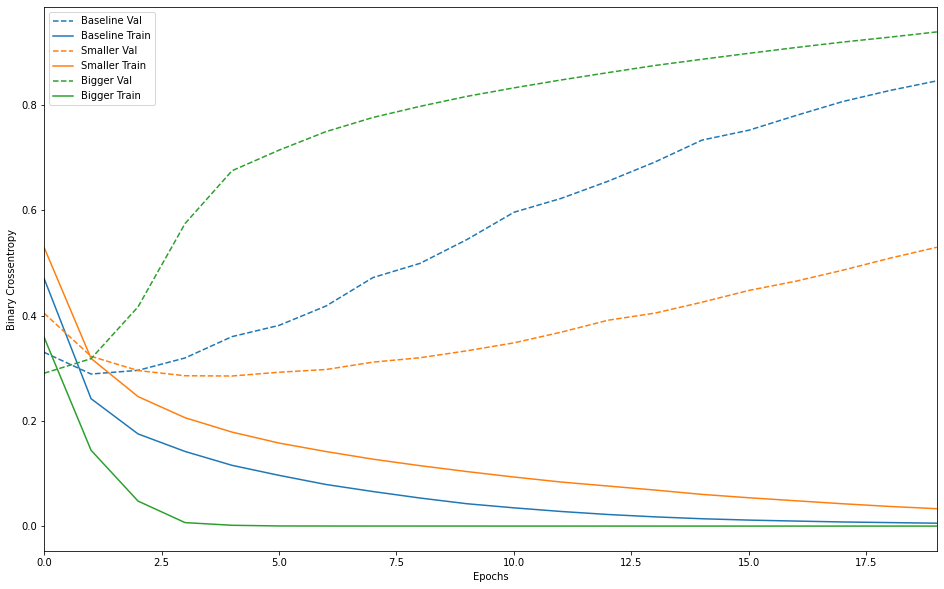

In [ ]:
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))
    
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])

より大きなネットワークでは、すぐに、1エポックで過学習が始まり、その度合も強いことに注目してください。ネットワークの容量が大きいほど訓練用データをモデル化するスピードが早くなり（結果として訓練時の損失値が小さくなり）ますが、より過学習しやすく（結果として訓練時の損失値と検証時の損失値が大きく乖離しやすく）なります。

## 過学習防止の戦略

### 重みの正則化を加える


「オッカムの剃刀」の原則をご存知でしょうか。何かの説明が2つあるとすると、最も正しいと考えられる説明は、仮定の数が最も少ない「一番単純な」説明だというものです。この原則は、ニューラルネットワークを使って学習されたモデルにも当てはまります。ある訓練用データとネットワーク構造があって、そのデータを説明できる重みの集合が複数ある時（つまり、複数のモデルがある時）、単純なモデルのほうが複雑なものよりも過学習しにくいのです。

ここで言う「単純なモデル」とは、パラメータ値の分布のエントロピーが小さいもの（あるいは、上記で見たように、そもそもパラメータの数が少ないもの）です。したがって、過学習を緩和するための一般的な手法は、重みが小さい値のみをとることで、重み値の分布がより整然となる（正則）様に制約を与えるものです。これを「重みの正則化」と呼ばれ、ネットワークの損失関数に、重みの大きさに関連するコストを加えることで行われます。このコストには2つの種類があります。

* [L1正則化](https://developers.google.com/machine-learning/glossary/#L1_regularization) 重み係数の絶対値に比例するコストを加える（重みの「L1ノルム」と呼ばれる）。

* [L2正則化](https://developers.google.com/machine-learning/glossary/#L2_regularization) 重み係数の二乗に比例するコストを加える（重み係数の二乗「L2ノルム」と呼ばれる）。L2正則化はニューラルネットワーク用語では重み減衰（Weight Decay）と呼ばれる。呼び方が違うので混乱しないように。重み減衰は数学的にはL2正則化と同義である。

L1正則化は重みパラメータの一部を0にすることでモデルを疎にする効果があります。L2正則化は重みパラメータにペナルティを加えますがモデルを疎にすることはありません。これは、L2正則化のほうが一般的である理由の一つです。

`tf.keras`では、重みの正則化をするために、重み正則化のインスタンスをキーワード引数として層に加えます。ここでは、L2正則化を追加してみましょう。

In [ ]:
l2_model = keras.models.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

l2_model_history = l2_model.fit(train_data, train_labels,
                                epochs=20,
                                batch_size=512,
                                validation_data=(test_data, test_labels),
                                verbose=2)

Epoch 1/20
49/49 - 2s - loss: 0.5183 - accuracy: 0.8157 - binary_crossentropy: 0.4766 - val_loss: 0.3881 - val_accuracy: 0.8696 - val_binary_crossentropy: 0.3438
Epoch 2/20
49/49 - 1s - loss: 0.3043 - accuracy: 0.9077 - binary_crossentropy: 0.2556 - val_loss: 0.3353 - val_accuracy: 0.8872 - val_binary_crossentropy: 0.2835
Epoch 3/20
49/49 - 1s - loss: 0.2539 - accuracy: 0.9297 - binary_crossentropy: 0.1997 - val_loss: 0.3411 - val_accuracy: 0.8852 - val_binary_crossentropy: 0.2850
Epoch 4/20
49/49 - 1s - loss: 0.2302 - accuracy: 0.9401 - binary_crossentropy: 0.1725 - val_loss: 0.3603 - val_accuracy: 0.8794 - val_binary_crossentropy: 0.3014
Epoch 5/20
49/49 - 1s - loss: 0.2161 - accuracy: 0.9474 - binary_crossentropy: 0.1556 - val_loss: 0.3682 - val_accuracy: 0.8786 - val_binary_crossentropy: 0.3067
Epoch 6/20
49/49 - 1s - loss: 0.2058 - accuracy: 0.9510 - binary_crossentropy: 0.1435 - val_loss: 0.3841 - val_accuracy: 0.8750 - val_binary_crossentropy: 0.3210
Epoch 7/20
49/49 - 1s - loss

```l2(0.001)```というのは、層の重み行列の係数全てに対して```0.001 * 重み係数の値 **2```をネットワークの損失値合計に加えることを意味します。このペナルティは訓練時のみに加えられるため、このネットワークの損失値は、訓練時にはテスト時に比べて大きくなることに注意してください。

L2正則化の影響を見てみましょう。

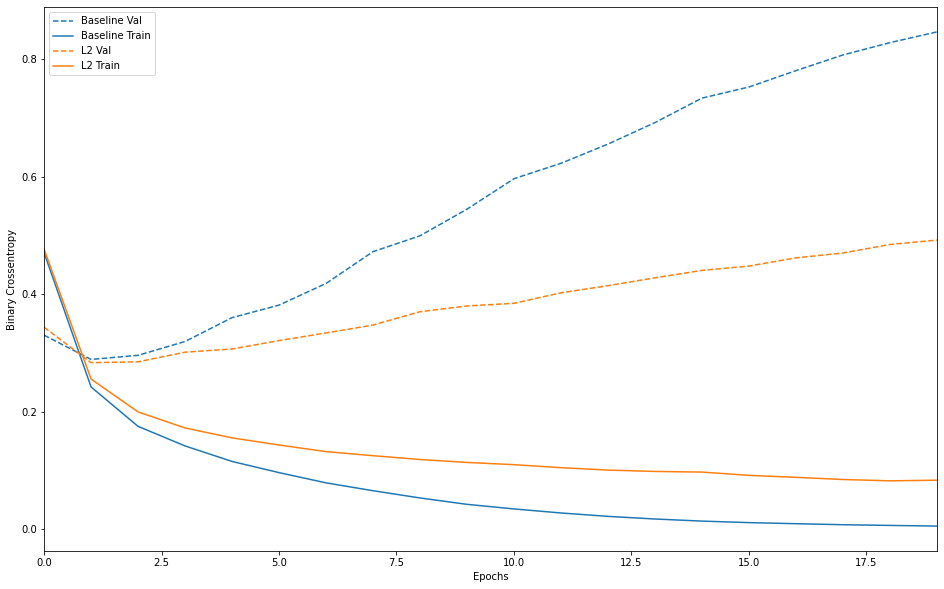

In [ ]:
plot_history([('baseline', baseline_history),
              ('l2', l2_model_history)])

ご覧のように、L2正則化ありのモデルは比較基準のモデルに比べて過学習しにくくなっています。両方のモデルのパラメータ数は同じであるにもかかわらずです。

### ドロップアウトを追加する

ドロップアウトは、ニューラルネットワークの正則化テクニックとして最もよく使われる手法の一つです。この手法は、トロント大学のヒントンと彼の学生が開発したものです。ドロップアウトは層に適用するもので、訓練時に層から出力された特徴量に対してランダムに「ドロップアウト（つまりゼロ化）」を行うものです。例えば、ある層が訓練時にある入力サンプルに対して、普通は`[0.2, 0.5, 1.3, 0.8, 1.1]` というベクトルを出力するとします。ドロップアウトを適用すると、このベクトルは例えば`[0, 0.5, 1.3, 0, 1.1]`のようにランダムに散らばったいくつかのゼロを含むようになります。「ドロップアウト率」はゼロ化される特徴の割合で、通常は0.2から0.5の間に設定します。テスト時は、どのユニットもドロップアウトされず、代わりに出力値がドロップアウト率と同じ比率でスケールダウンされます。これは、訓練時に比べてたくさんのユニットがアクティブであることに対してバランスをとるためです。

`tf.keras`では、Dropout層を使ってドロップアウトをネットワークに導入できます。ドロップアウト層は、その直前の層の出力に対してドロップアウトを適用します。

それでは、IMDBネットワークに2つのドロップアウト層を追加しましょう。

In [ ]:
dpt_model = keras.models.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

dpt_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy','binary_crossentropy'])

dpt_model_history = dpt_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Epoch 1/20
49/49 - 2s - loss: 0.5988 - accuracy: 0.6824 - binary_crossentropy: 0.5988 - val_loss: 0.4352 - val_accuracy: 0.8639 - val_binary_crossentropy: 0.4352
Epoch 2/20
49/49 - 1s - loss: 0.4107 - accuracy: 0.8357 - binary_crossentropy: 0.4107 - val_loss: 0.3143 - val_accuracy: 0.8839 - val_binary_crossentropy: 0.3143


In [ ]:
plot_history([('baseline', baseline_history),
              ('dropout', dpt_model_history)])

ドロップアウトを追加することで、比較対象モデルより明らかに改善が見られます。

まとめ：ニューラルネットワークにおいて過学習を防ぐ最も一般的な方法は次のとおりです。

* 訓練データを増やす
* ネットワークの容量をへらす
* 重みの正則化を行う
* ドロップアウトを追加する

このガイドで触れていない２つの重要なアプローチがあります。データ拡張とバッチ正規化です。